In [ ]:
#Imports
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  
import matplotlib.dates as mdates
'''%pip install --upgrade pip
%pip uninstall pyodbc -y
%pip install -U pyodbc
%pip install xgboost
%pip install pandas==2.0.3
%pip install scikit-learn
%pip install "numpy<1.24"
%pip install==3.10.0'''
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.compat.pandas import PD_LT_2
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_percentage_error

#### Introduction for this Notebook: We will be refactoring the previous code into resuable functions which will generate the time series charts showing actuals and predictions computed by the algorithms. We will also perform comparison of algorithms with respect to MAPE.

### Function to import csv file and filter by given variables to create a graph for a given FacilityID

In [3]:
def gather_and_filter_data(year, state, regioncode, parentlocation, parentlocationid, facilityid, usetype, inventorytype, equipmentdescriptions, columns_to_drop):
    df = pd.read_csv(f'reservation_{year}.csv')
    # Filter out irrelevant rows
    df = df[(df['facilitystate'] == state) & (df['usetype'] == usetype) & (df['inventorytype'] == inventorytype)  & (df['equipmentdescription'].isin(equipmentdescriptions))]

    df = df[(df['regioncode'] == regioncode) & (df['parentlocation'] == parentlocation) & (df['parentlocationid'] == parentlocationid)  & (df['facilityid'] == facilityid)]

    df = df[df['startdate'] > f'{year}-00-00']
    # Filter out irrelevant columns
    df = df.drop(columns=columns_to_drop, errors='ignore')
    return df

### Function to create column transformations and adding new calculated columns.

In [4]:
def transform_columns(df):
    columns_to_convert = ['numberofpeople']
    df[columns_to_convert].astype('int')

    # Convert Number of nights to integer and remove the string 
    df['numeric_nights'] = df['nights'].str.replace(' days', '').str.replace(' day', '').fillna('0').astype(int)
    df['numeric_nights'] = np.where(df.numeric_nights < 0, 0, df.numeric_nights)

    #Convert columns to numeric
    df['parentlocationid'] = pd.to_numeric(df['parentlocationid'], errors='coerce')
    df['productid'] = pd.to_numeric(df['productid'], errors='coerce')
    df['nights'] = pd.to_numeric(df['nights'], errors='coerce')

    #Convert columns to datetime
    df['orderdate_dt'] = pd.to_datetime(df['orderdate'], errors='coerce')
    df['start_dt'] =  pd.to_datetime(df['startdate'], errors='coerce')
    df['end_dt'] =  pd.to_datetime(df['enddate'], errors='coerce')

    # Perform calculations to find how many sites are booked for a given date. eg. if for a given facility ID there is one booking from 3-5 July and another booking is from 4-5 July then for 3 July we have 1 booking, for 4th we have 2 bookings and for 5th we have 0 bookings.
    # Compute day difference
    df['delta_end_to_start'] = (df['end_dt'] - df['start_dt']).dt.days
    df['delta_end_to_start'] = df['delta_end_to_start'].fillna(0).astype(int)

    # Convert start dates to NumPy array
    start_dates = df['start_dt'].to_numpy()
    delta_end_to_start = df['delta_end_to_start'].to_numpy()

    # Expand date ranges
    dates = []
    for idx, date in enumerate(start_dates):
        days = delta_end_to_start[idx]
        for day in range(days + 1):
            next_date = date + datetime.timedelta(days=day)
            dates.append(next_date)

    # Create DataFrame
    date_freq_df = pd.DataFrame({'date': dates})
    date_freq_df['bookings'] = date_freq_df['date'].map(date_freq_df['date'].value_counts())
    date_freq_df.columns = ['date', 'bookings']


    # Convert 'date' column to datetime if not already done
    date_freq_df['date'] = pd.to_datetime(date_freq_df['date'])

    # Set 'date' as the index and sort it
    date_freq_df.set_index('date', inplace=True)
    date_freq_df = date_freq_df.sort_index()

    # Store the final DataFrame for plotting
    plot_data = date_freq_df.reset_index()

    #convert the plot_data to a csv file
    plot_data.to_csv('one_timeseries.csv')

    plot_data['date'] = pd.to_datetime(plot_data['date'])  
    plot_data.set_index('date', inplace=True)       
    return plot_data

### Function to create lagged features

In [5]:
def create_lagged_stats(plot_data, target_col, window_size=2):

    df_lagged = plot_data.copy() # This will create a copy of existing dataframe and assign it to new df_lagged. Next we will add the lagged columns as features to the df_lagged.
    
    # Create lagged statistical features
    df_lagged[f'{target_col}_min_lag'] = plot_data[target_col].shift(1).rolling(window=window_size).min()
    df_lagged[f'{target_col}_max_lag'] = plot_data[target_col].shift(1).rolling(window=window_size).max()
    df_lagged[f'{target_col}_mean_lag'] = plot_data[target_col].shift(1).rolling(window=window_size).mean()
    df_lagged[f'{target_col}_std_lag'] = plot_data[target_col].shift(1).rolling(window=window_size).std()

    # Drop rows with NaN values caused by rolling window
    df_lagged.dropna(inplace=True)

    return df_lagged

### Function to perform sequential train and test split of the data

In [6]:
def sequential_train_test_split(plot_data, train_ratio, feature_columns, label_column):
        train_size = int(len(plot_data) * train_ratio)

        # Sequential split
        train_df = plot_data.iloc[:train_size]
        test_df = plot_data.iloc[train_size:]

        #print(f"Train size: {train_df.shape}, Test size: {test_df.shape}")
        #print("Train Data Sample:\n", train_df.head(2))
        #print("Train Data Sample:\n", test_df.head(2))
        
        # Separate Features and Label 
        X_train, y_train = train_df[feature_columns], train_df[label_column]
        X_test, y_test = test_df[feature_columns], test_df[label_column]

        # Display the shapes for verification
        #print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        #print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
        return X_train, y_train, X_test, y_test, train_df.index.values, test_df.index.values # takes the training dates where they are stored as an index in original dataframe


### Function to find if there exists time gap

In [7]:
def find_two_day_gaps(plot_data):
    # Compute time differences on the index (date column)
    time_diffs = plot_data.index.to_series().diff()
    
    # Filter rows where the time difference is exactly 2 days
    two_day_gaps = plot_data.index[time_diffs == pd.Timedelta(days=2)]
    
    return two_day_gaps, time_diffs
# Call function and print results
#gaps, diffs = find_two_day_gaps(plot_data)
#print("Dates where time gap is 2 days:\n", gaps)

### Function to resolve Time gap if it exists

In [8]:
def handle_time_gaps(df, date_column, value_column):
    # Ensure the date column is in datetime format
    df[date_column] = pd.to_datetime(df[date_column])
    
    # Sort the DataFrame by date
    df = df.sort_values(by=date_column)
    
    # Calculate the difference between consecutive dates
    df['date_diff'] = df[date_column].diff().dt.days
    
    # Set values to 0 where the gap is greater than 1 day
    df.loc[df['date_diff'] > 1, value_column] = 0
    
    # Drop the temporary 'date_diff' column
    df.drop(columns=['date_diff'], inplace=True)
    
    return df

### Function to define 3 Models Linear Regression, Random Forest, XGBoost. Evaluate the Models and plot graphs for Actuals vs Predictions for each model.

In [9]:
def train_linear_regression(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def train_random_forrest(X_train, y_train):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

def train_xgboost(X_train, y_train):
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    return model

def evalute_model(model, X_test, y_test, is_plot_graph=False):
    y_pred = model.predict(X_test)

    # Evaluate Model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mape_percent = str(round(mape * 100, 2)) + "%"

    print("\n--- Error Metrics ---")
    print(f"MAE: {mae:.3f}")
    print(f"MSE: {mse:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print("MAPE:", mape_percent)

    # Plot Actual vs Predictions
    df_plot = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})

    if is_plot_graph:
        # Plot using Seaborn
        plt.figure(figsize=(6, 6))
        sns.scatterplot(x=y_test, y=y_pred, color='blue', s=50)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)  # Perfect Prediction Line

        plt.xlabel('No. of True Bookings')
        plt.ylabel('No. of Predicted Bookings')
        plt.title('No. of True Bookings vs No. of Predicted Bookings')
        #plt.legend()
        plt.legend(['Perfect Prediction Line', 'Predicted Values'], loc='lower right')
        plt.grid(True)
        plt.show()
    return y_test, y_pred, mape_percent


### Create a function that will take parent location,parent locationId and facilityID as inputs and generate time series graphs for each facilityID

In [28]:
def create_california_timeseries (parentlocation, parentlocationid, facilityid):
    usetype='Overnight'
    inventorytype = 'CAMPING'
    equipmentdescriptions = ['Tent', 'Large Tent Over 9X12`', 'Small Tent', 'RV', 'Trailer']
    columns_to_drop = ['ordernumber','orgid','codehierarchy','facilityzip', 'facilitylongitude', 'facilitylatitude', 'tax', 'usefee', 'tranfee', 'attrfee', 'totalbeforetax', 'discount', 'totalpaid','historicalreservationid','customerzip']

    df = gather_and_filter_data(year='2023', state='California', regioncode='R05', parentlocation=parentlocation, parentlocationid=parentlocationid, facilityid=facilityid,
                                usetype=usetype,
                                inventorytype=inventorytype,
                                equipmentdescriptions=equipmentdescriptions,
                                columns_to_drop=columns_to_drop)
    df = transform_columns(df)

    label_column = 'bookings'
    feature_columns = ['bookings_min_lag', 'bookings_max_lag', 'bookings_mean_lag', 'bookings_std_lag']

    train_ratio = 0.7
    df_lagged = create_lagged_stats(df, target_col='bookings', window_size=2)
    X_train, y_train, X_test, y_test, train_dates, test_dates = sequential_train_test_split(df_lagged, train_ratio, feature_columns, label_column)

    model = train_linear_regression(X_train, y_train)
    lr_y_test, lr_y_pred, mape_lr = evalute_model(model, X_test, y_test)

    model = train_random_forrest(X_train, y_train)
    rf_y_test, rf_y_pred, mape_rf = evalute_model(model, X_test, y_test)

    model = train_xgboost(X_train, y_train)
    xg_y_test, xg_y_pred, mape_xg = evalute_model(model, X_test, y_test)

    error_metrics = pd.DataFrame({
        'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
        'mape_percent': [mape_lr, mape_rf, mape_xg]
    })

    # Display the table
    print(error_metrics)

    #Combine the dates and labels
    all_dates = train_dates.tolist() # convert training dates to a list
    all_dates.extend(test_dates) # combine training and testing dates to a single list ( booking dates)

    booking_labels = y_train.values.tolist() #convert label dates to a list
    booking_labels.extend(y_test) # combine labels for test and train (No.of bookings)

    lr_all = [None for _ in range(len(train_dates))] # in this loop initially for train side of graph we put none values and then extend predictions to test dates side.
    lr_all.extend(lr_y_pred)

    rf_all = [None for _ in range(len(train_dates))]
    rf_all.extend(rf_y_pred)

    xg_all = [None for _ in range(len(train_dates))]
    xg_all.extend(xg_y_pred)

    # Perform Sanity checks for number of rows and columns for below time series plot.
    # Get total count of elements
    total_count = len(all_dates)
    print(total_count) 

    total_labels=len(booking_labels)
    print(total_labels)

    totl_lr=len(lr_all)
    print(totl_lr)

    totl_rf=len(rf_all)
    print(totl_lr)

    totl_xg=len(xg_all)
    print(totl_xg)

    
    #Ensure all_dates is in datetime format
    all_dates = pd.to_datetime(all_dates)
    # Plot using Seaborn
    plt.figure(figsize=(20, 11))
    sns.lineplot(x=all_dates, y=booking_labels, color='Blue',linewidth=2, label='True Values',ci=None)
    sns.lineplot(x=all_dates, y=lr_all, color='#DC143C',linewidth=3, linestyle='--',ci=None)
    sns.lineplot(x=all_dates, y=rf_all,  color='Green',linewidth=3.5, linestyle='-.', label='Random Forest Pred',ci=None)
    sns.lineplot(x=all_dates, y=xg_all, color='Orange',linewidth=3.5, linestyle=':', label='XGBoost Pred',ci=None)

    # Convert lists to numpy arrays
    booking_labels = np.array(booking_labels)
    lr_all = np.array(lr_all)
    rf_all = np.array(rf_all)
    xg_all = np.array(xg_all)


    plt.xlabel('Dates',fontsize=18)
    plt.ylabel('No. of Bookings',fontsize=18)
    plt.title(f'Comparison of Linear Regression, Random Forest and XGBoost models Performance for No.of Bookings Prediction for FacilityID={facilityid}', fontsize=18)

    plt.legend(['True Values', 'Linear Regression Pred', 'Random Forest Pred', 'XGBoost Pred'], loc='upper left',fontsize=15)
    plt.grid(True,which='both', linestyle='--', color='lightgrey', alpha=0.7)
    plt.xticks(fontsize=18,rotation=90)  # Rotate labels 90 degrees

    ax = plt.gca()
    for ind, label in enumerate(ax.get_xticklabels()):
        if ind % 1 == 0:  
            label.set_visible(True)
        else:
            label.set_visible(False)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Set x-axis gridline interval to every 3 months

    plt.show()


### Running a loop for all the 5 facilityIDs from a list

#### Below function will create Time series graphs for 5 FacilityIDS in different National Forests. 

<ipython-input-3-14992d74c69a>:2: DtypeWarning: Columns (7,11,12,13,15,17,27,29,31,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'reservation_{year}.csv')



--- Error Metrics ---
MAE: 0.344
MSE: 9.340
RMSE: 3.056
MAPE: 0.41%

--- Error Metrics ---
MAE: 3.258
MSE: 177.749
RMSE: 13.332
MAPE: 13.35%

--- Error Metrics ---
MAE: 3.331
MSE: 179.872
RMSE: 13.412
MAPE: 13.42%
               Model mape_percent
0  Linear Regression        0.41%
1      Random Forest       13.35%
2            XGBoost       13.42%
21020
21020
21020
21020
21020


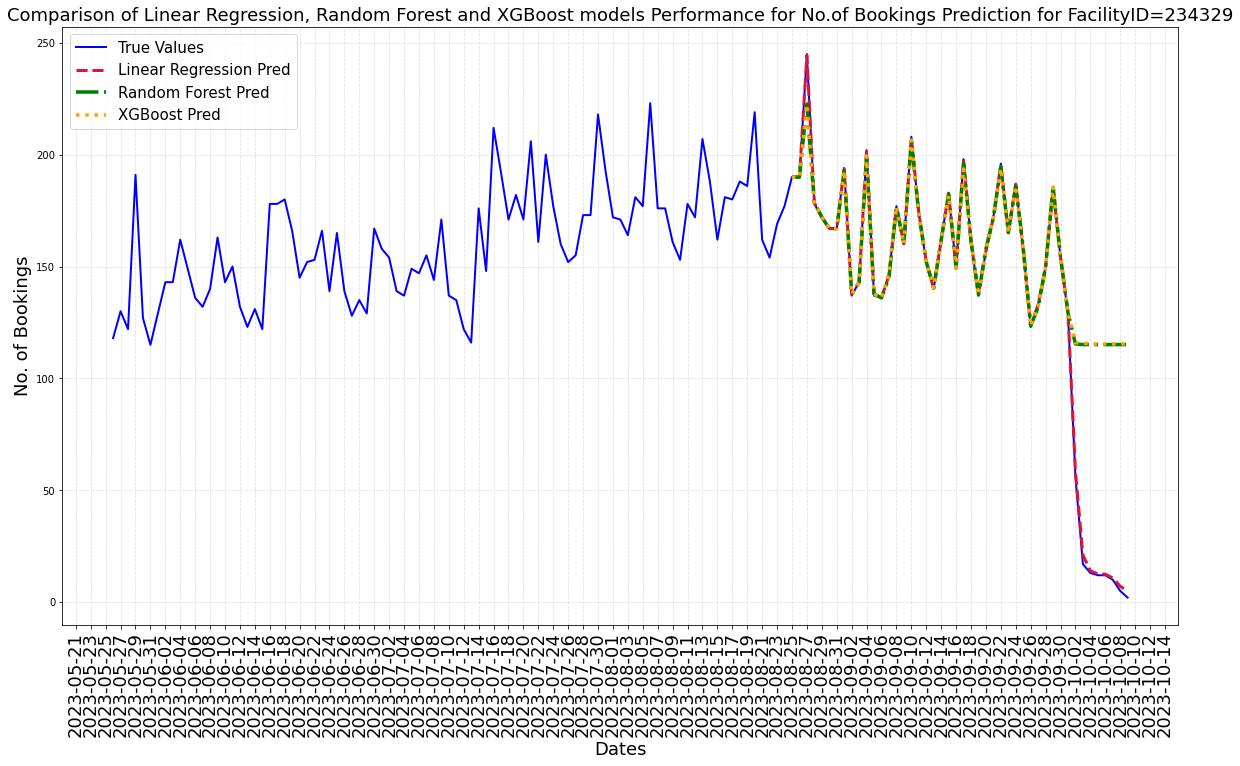

<ipython-input-3-14992d74c69a>:2: DtypeWarning: Columns (7,11,12,13,15,17,27,29,31,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'reservation_{year}.csv')



--- Error Metrics ---
MAE: 0.735
MSE: 47.571
RMSE: 6.897
MAPE: 0.97%

--- Error Metrics ---
MAE: 4.944
MSE: 180.080
RMSE: 13.419
MAPE: 17.26%

--- Error Metrics ---
MAE: 5.798
MSE: 189.408
RMSE: 13.763
MAPE: 17.89%
               Model mape_percent
0  Linear Regression        0.97%
1      Random Forest       17.26%
2            XGBoost       17.89%
23590
23590
23590
23590
23590


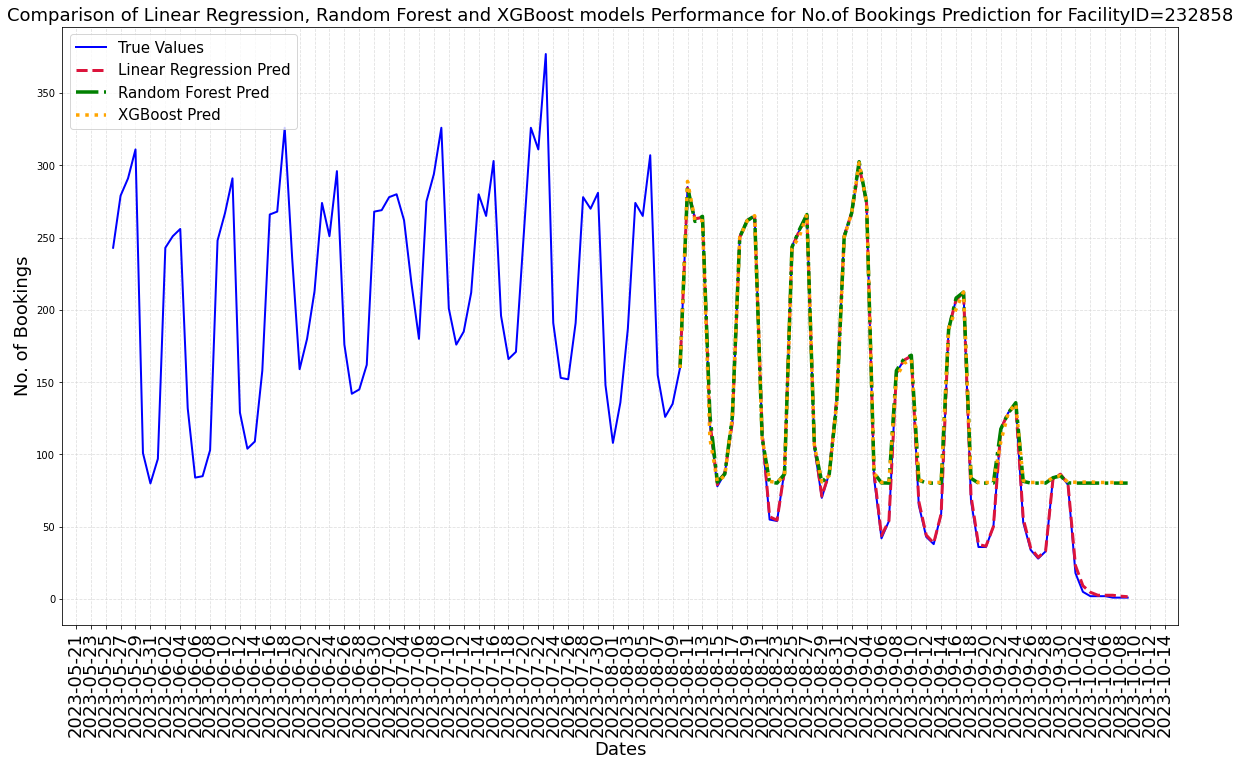

<ipython-input-3-14992d74c69a>:2: DtypeWarning: Columns (7,11,12,13,15,17,27,29,31,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'reservation_{year}.csv')



--- Error Metrics ---
MAE: 0.778
MSE: 20.252
RMSE: 4.500
MAPE: 2.61%

--- Error Metrics ---
MAE: 1.651
MSE: 24.156
RMSE: 4.915
MAPE: 6.68%

--- Error Metrics ---
MAE: 2.048
MSE: 25.163
RMSE: 5.016
MAPE: 7.36%
               Model mape_percent
0  Linear Regression        2.61%
1      Random Forest        6.68%
2            XGBoost        7.36%
9069
9069
9069
9069
9069


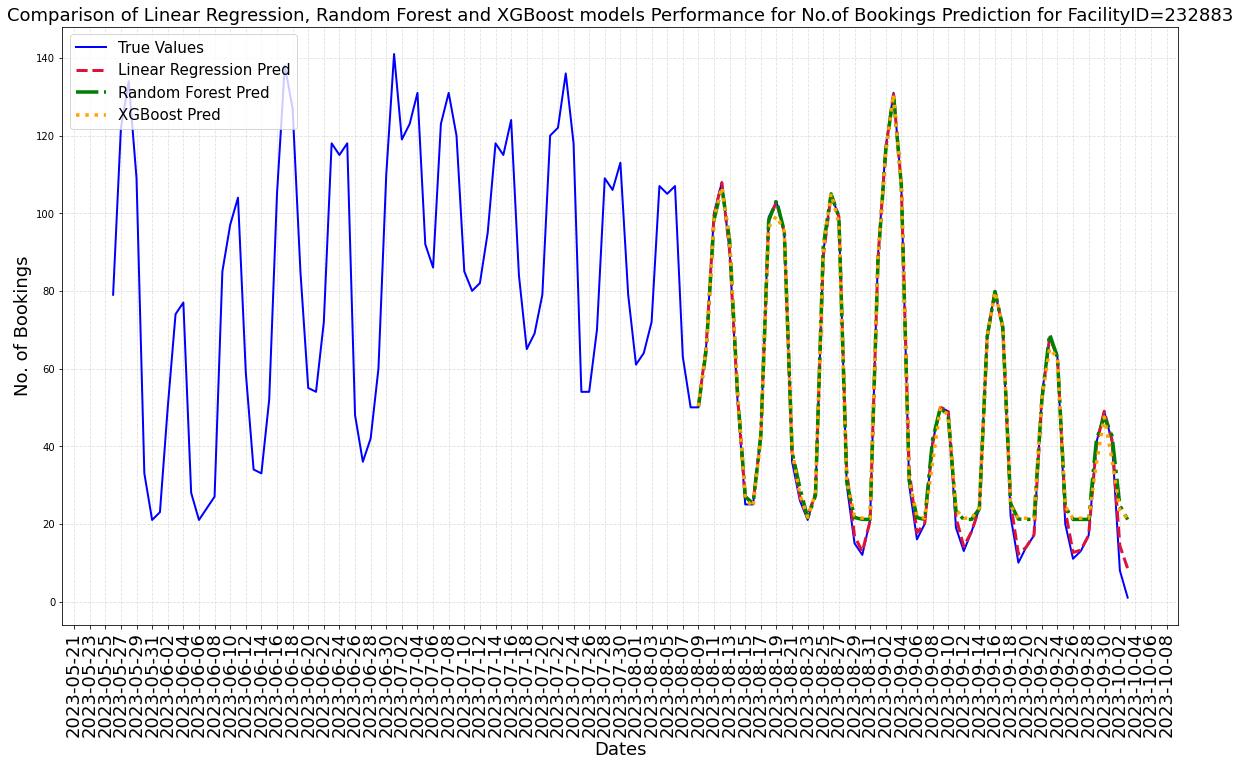

<ipython-input-3-14992d74c69a>:2: DtypeWarning: Columns (7,11,12,13,15,17,27,29,31,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'reservation_{year}.csv')



--- Error Metrics ---
MAE: 0.453
MSE: 11.120
RMSE: 3.335
MAPE: 0.88%

--- Error Metrics ---
MAE: 1.078
MSE: 13.779
RMSE: 3.712
MAPE: 2.16%

--- Error Metrics ---
MAE: 1.446
MSE: 17.881
RMSE: 4.229
MAPE: 2.71%
               Model mape_percent
0  Linear Regression        0.88%
1      Random Forest        2.16%
2            XGBoost        2.71%
13693
13693
13693
13693
13693


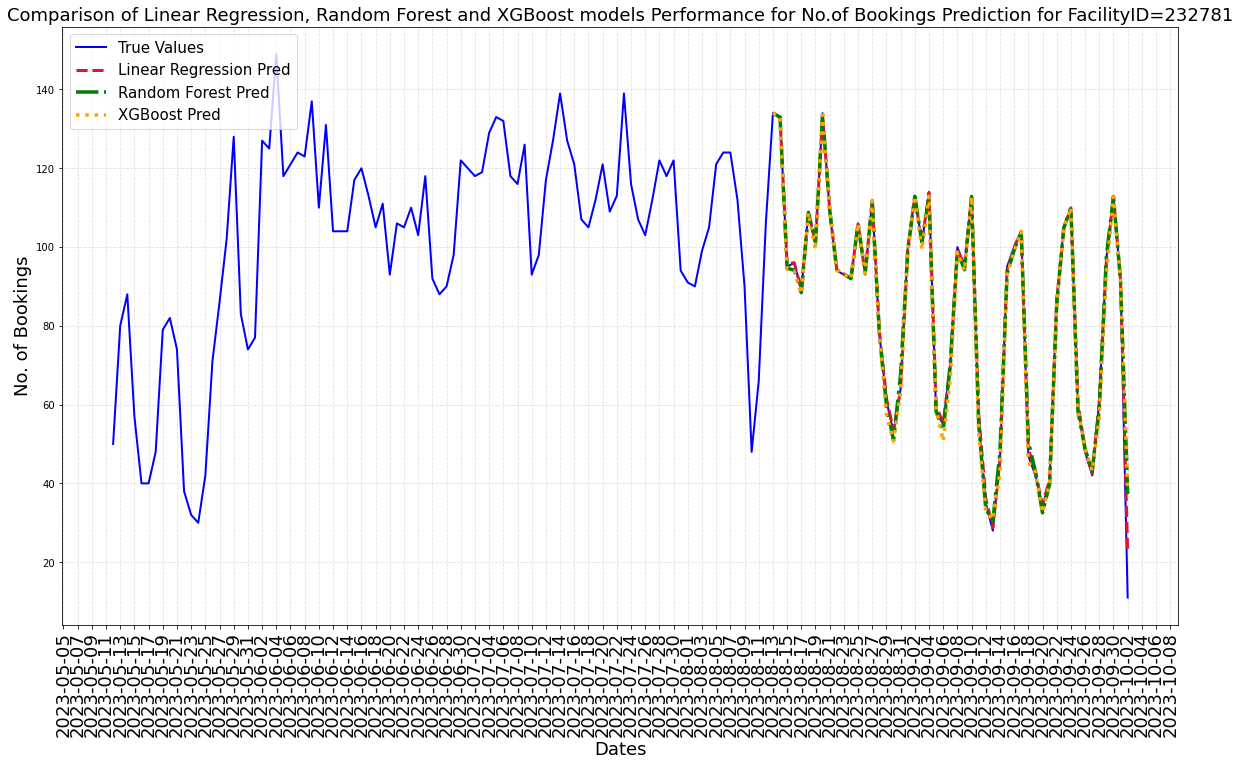

<ipython-input-3-14992d74c69a>:2: DtypeWarning: Columns (7,11,12,13,15,17,27,29,31,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'reservation_{year}.csv')



--- Error Metrics ---
MAE: 0.704
MSE: 21.817
RMSE: 4.671
MAPE: 1.8%

--- Error Metrics ---
MAE: 1.109
MSE: 24.166
RMSE: 4.916
MAPE: 2.5%

--- Error Metrics ---
MAE: 1.697
MSE: 26.760
RMSE: 5.173
MAPE: 3.49%
               Model mape_percent
0  Linear Regression         1.8%
1      Random Forest         2.5%
2            XGBoost        3.49%
12500
12500
12500
12500
12500


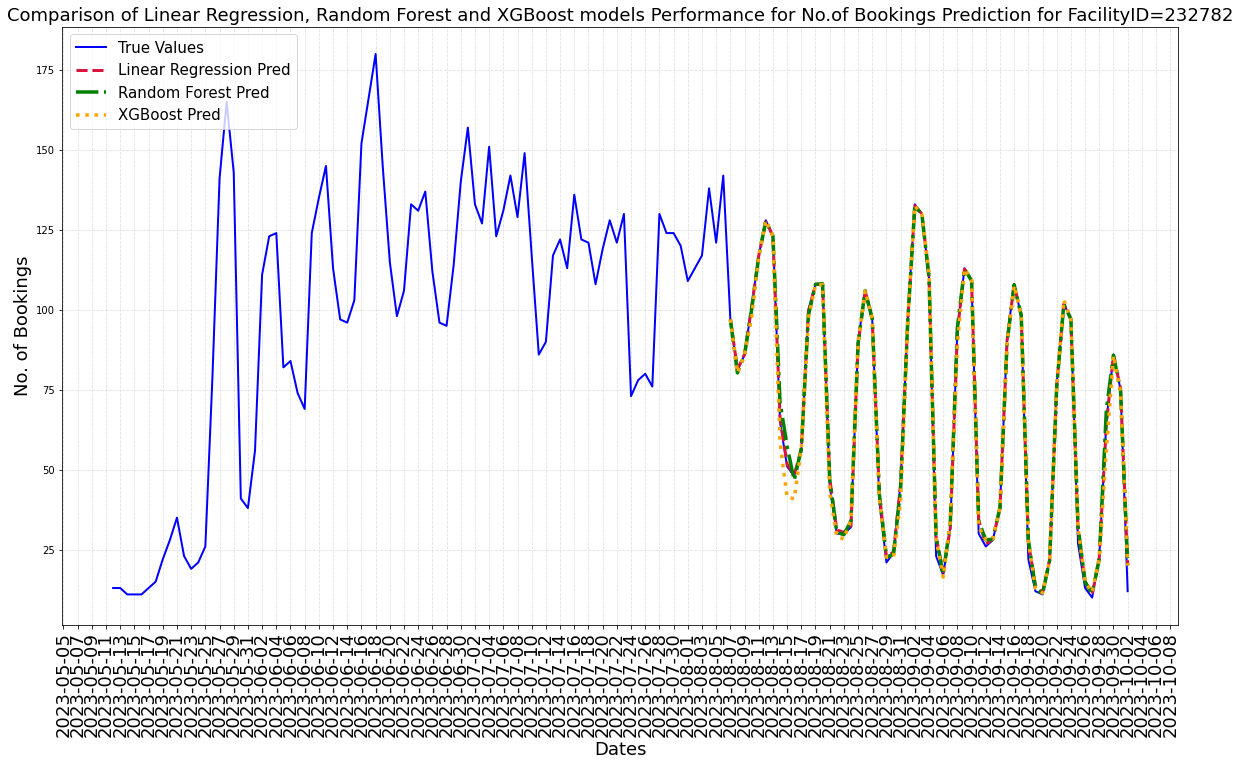

In [35]:
for parentlocation, parentlocationid, facilityid in [('Inyo National Forest', 74804.0, 234329),
                                                     ('Tahoe National Forest', 74838.0, 232858),
                                                     ('Tahoe National Forest', 74838.0, 232883),
                                                     ('Sequoia National Forest', 74823.0, 232781),
                                                     ('Sequoia National Forest', 74823.0, 232782)]:
    create_california_timeseries(parentlocation, parentlocationid, facilityid)

#### Summary
1. The Facility IDs were selected from various National Forests in California to ensure geographical diversity in our model training. This approach helps improve the model's generalizability across different locations and booking patterns.
2. The Linear Regression Model demonstrates superior forecasting accuracy compared to Random Forest and XGBoost, as reflected in its lower Mean Absolute Percentage Error (MAPE) and closer alignment with actual booking trends.